# RIAA Filter
This investigates different implementations of the [RIAA equalization](https://en.wikipedia.org/wiki/RIAA_equalization)

It investigates a forum post that came up with a set of RIAA parameters from reverse-engineering an analog design. It then traces these parameters to the source-code of `sox`, a
[Cross-platform Audio-Editing software](https://en.wikipedia.org/wiki/SoX)

[Official sox homepage](http://sox.sourceforge.net/)

We finally try to derive the correct RIAA parameters.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
%matplotlib inline
from filter_optimizer.filterplot import plot_response, plot_delay, pole_zero_plot

In [3]:
def update_conjugate_complex (numbers) :
    """ Modify numbers in-place to add conjugate complex numbers"""
    n2 = [k.conjugate () for k in numbers if k.imag]
    numbers.extend (n2)

In [4]:
def compute_analog_filter (zeros, poles) :
    """ Compute analog filter from given zeros and poles
        Note that we normalize the filter to 0dB gain @zkHz
        See below for the conversion of T to f
    """
    filts  = signal.lti (-1 / (zeros * np.pi * 2), -1 / (poles * np.pi * 2), 1.0)
    w, h   = signal.freqs_zpk (filts.zeros, filts.poles, filts.gain, [1000])
    filts.gain = filts.gain / abs (h [0])
    return filts

### Audacity RIAA parameters
The Software Audacity contains a RIAA curve specified as a list of frequency/gain pairs.
RIAA Parameters (curve) from source-code of
[Audacity](https://www.audacityteam.org/) in the file `presets/EQDefaultCurves.xml`:

In [5]:
# Audacity RIAA curve
# Note that the first two values for 5 and 5 Hz
# and the values at the filter points
# were added by hand from analog filter
audacity_riaa = \
[ (5.00,     19.868)
, (10.00,    19.743)
, (20.00,    19.274)
, (25.00,    18.954)
, (31.00,    18.516)
, (40.00,    17.792)
, (50.00,    16.946)
, (63.00,    15.852)
, (80.00,    14.506)
, (100.00,   13.088)
, (125.00,   11.563)
, (160.00,    9.809)
, (200.00,    8.219)
, (250.00,    6.677)
, (315.00,    5.179)
, (400.00,    3.784)
, (500.00,    2.648)
, (630.00,    1.642)
, (800.00,    0.751)
, (1000.00,   0.000)
, (1250.00,  -0.744)
, (1600.00,  -1.643)
, (2000.00,  -2.589)
, (2500.00,  -3.700)
, (3150.00,  -5.038)
, (4000.00,  -6.605)
, (5000.00,  -8.210)
, (6300.00,  -9.980)
, (8000.00,  -11.894)
, (10000.00, -13.734)
, (12500.00, -15.609)
, (16000.00, -17.708)
, (20000.00, -19.620)
, (25000.00, -21.542)
, (48000.00, -27.187)
]

audacity_frq = np.array ([k for k, v in audacity_riaa])

# From https://www.stereophile.com/features/cut_and_thrust_riaa_lp_equalization/index.html
# Note that they are given here with more precicion derived from analog filter
curve_stereophile_riaa = \
[ (500.50,   2.6429)
, (2122.00, -2.8665)
]

def plot_range (fs, plotrange = None) :
    """ Range of frequencies limited to sample frequency fs / 2
        If no plotrange is given, plot from 5 to fs/2 in 5 Hz steps
    """
    if plotrange is None :
        plotrange = np.array (range (5, int (fs / 2) + 5, 5))
    else :
        plotrange = np.array ([x for x in plotrange if x <= fs / 2])
    return plotrange

def plot_range_digi (fs, plotrange = None) :
    plotrange = plot_range (fs, plotrange)
    return plotrange / fs * np.pi * 2

def compare_to_audacity (a, b, fs, with_stereophile = False) :
    curve = audacity_riaa [:]
    if with_stereophile :
        curve = sorted (audacity_riaa + curve_stereophile_riaa, key = lambda x: x [0])
        
    aud_frq = np.array (list (k for k, v in curve if k <= fs / 2))
    aud_db  = np.array (list (v for k, v in curve if k <= fs / 2))
    
    frq = aud_frq / fs * 2 * np.pi
    w, h = signal.freqz (b, a, frq)
    db = 20 * np.log10 (abs (h))
    
    fig = plt.figure ()
    ax1 = fig.add_subplot (111)
    ax1.set_xscale ('log')
    plt.title ('Gain Error @%s kHz' % (fs / 1000))
    
    plt.plot (aud_frq, db - aud_db, 'b')
    plt.ylabel ('Amplitude dB Difference from Audacity', color = 'b')
    plt.xlabel ('Freq (Hz)')
    plt.grid (which = 'both')

## RIAA Parameters from Wikipedia
[Stereophile Article](https://www.stereophile.com/features/cut_and_thrust_riaa_lp_equalization/index.html) defines that the time constants are converted to frequencies as follows:
$$ f = \frac{1}{2\pi{}T} $$
We need frequencies for the analog filter in `scipy.filter`

[19.86829768 19.74264712 19.27414837  2.64288871 -2.86645192]


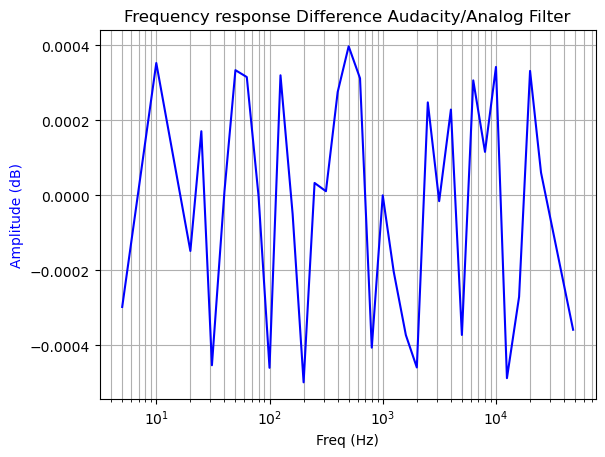

In [6]:
# For now we're only using the riaa parameter set.
# Note that the others are not really tested and the 'flat' seems to be wrong
riaa = dict (szero = np.array ([318e-6]), spole = np.array ([3180e-6, 75e-6]), name = 'riaa')
bbc  = dict (szero = np.array ([318e-6]), spole = np.array ([3180e-6, 50e-6]), name = 'bbc')
flat = dict (szero = np.array ([319e-6]), spole = np.array ([3180e-6]), name = 'flat')
iec  = dict (szero = np.array ([318e-6]), spole = np.array ([3180e-6, 75e-6, 7950e-6]), name = 'iec')
riaa_analog  = compute_analog_filter (riaa ['szero'], riaa ['spole'])
r_a_w, r_a_h = signal.freqs_zpk (riaa_analog.zeros, riaa_analog.poles, riaa_analog.gain, audacity_frq)

# Additional values, see tables above
w_tmp, h_tmp = signal.freqs_zpk (riaa_analog.zeros, riaa_analog.poles, riaa_analog.gain, [5., 10., 20., 500.50, 2122.00])
print (20 * np.log10 (abs (h_tmp)))
fs   = audacity_frq [-1] * 2
rd   = plot_range_digi (fs, audacity_frq)
ah   = np.power ([10] * len (rd), np.array ([v for k, v in audacity_riaa]) / 20)
plot_response (rd, abs (ah) / abs (r_a_h [:len(rd)]), fs = fs, title = 'Difference Audacity/Analog Filter', logx=1)

[Forum Post](https://www.musicdsp.org/en/latest/Filters/122-digital-riaa-equalization-filter-coefficients.html)
Claims the following:

    The s-domain transfer function is

    R3(1+R1*C1*s)(1+R2*C2*s)/(R1(1+R2*C2*s) + R2(1+R1*C1*s) +
    R3(1+R1*C1*s)(1+R2*C2*s))

    where
    `R1 = 883.3k`
    `R2 = 75k`
    `R3 = 604`
    `C1 = 3.6n`
    `C2 = 1n`
    This is based on the reference circuit found in http://www.hagtech.com/pdf/riaa.pdf
    The coefficients of the digital transfer function `b(z^-1)/a(z^-1)`
    in descending powers of z, are:

Note: This is the *inverse* RIAA (for recording not for playback)
and one of 44.1 kHz or 48 kHz is wrong (they're identical).
Also note that the analog circuit that was used as a basis of
reverse engineering claims that in the original recording
equipment there was a pole at 3.18µs (about 50kHz). This has been
disputed in 2009 in an
[article by Keith Howard in "stereophile"](https://www.stereophile.com/content/cut-and-thrust-riaa-lp-equalization-page-2)

The analog circuit realizing this pole for playback by Jim Hagerman in linked here:
[Link to analog circuit](http://www.hagtech.com/pdf/riaa.pdf)

Parameters from the forum post for recording:

#### 44.1kHz
```
b = [ 0.02675918611906  -0.04592084787595   0.01921229297239]
a = [ 1.00000000000000  -0.73845850035973  -0.17951755477430]
error +/- 0.25dB
```
#### 48kHz
```
b = [  0.02675918611906  -0.04592084787595   0.01921229297239]
a = [  1.00000000000000  -0.73845850035973  -0.17951755477430]
error +/- 0.15dB
```
#### 88.2kHz
```
b = [  0.04872204977233  -0.09076930609195   0.04202280710877]
a = [ 1.00000000000000  -0.85197860443215  -0.10921171201431]
error +/- 0.01dB
```
#### 96kHz
```
b = [ 0.05265477122714  -0.09864197097385   0.04596474352090  ]
a = [  1.00000000000000  -0.85835597216218  -0.10600020417219 ]
error +/- 0.006dB
```

Later post in same forum thread:

    FYI, here are working filter coefficients for biquad implementation
    of RIAA EQ Reproduction filters:

An the paramters, now with *different* sets for 44.1kHz and 48kHz:

#### 44.1kHz:
```
a = [ 1.0000000000 -1.7007240000  0.7029381524 ]
b = [ 1.0000000000 -0.7218922000 -0.1860520545 ]
error ~0.23dB
```
#### 48kHz:
```
a = [ 1.0000000000 -1.7327655000  0.7345534436 ]
b = [ 1.0000000000 -0.7555521000 -0.1646257113 ]
error ~0.14dB
```
#### 88.2kHz:
```
a = [ 1.0000000000 -1.8554648000  0.8559721393 ]
b = [ 1.0000000000 -0.8479577000 -0.1127631993 ]
error 0.008dB
```
#### 96kHz:
```
a = [ 1.0000000000 -1.8666083000  0.8670382873 ]
b = [ 1.0000000000 -0.8535331000 -0.1104595113 ]
error ~0.006dB
```
```
#### NOTES in Forum:
All these given filter coefficients produces a bit gained filter
(~+12.5dB or so) so, if you like to adjust the 1 kHz = 0dB, it can
be done quite accurately by finding linear difference using software
like Tobybear's FilterExplorer. Enter coefficients into
FilterExplorer, by moving mouse cursor over the plotted magnitude
curve in magnitude plot window, find/point the ~1kHz position and
then check the magnitude value (value inside the brackets) found in
info field. Use this value as divider for b coefficients.

#### Notes (by me):
It looks like the original analog circuit that was reverse-engineered
here has a pole at around 50kHz. To make such a high frequency pole
work the system must have a sampling rate of > 100kHz. So for all these
lower sampling rates the pole will be aliased (!) to a lower frequency.

In the following we check these parameters and print the zeros and
poles for this configuration.

In [7]:
# Coefficients from the forum post.
# Note that either the 44.1 or the 48 kHz value is bogus
# These are the *recording* values not the playback values
riaa_record_from_forum = \
{   '44.1' :
    dict
        ( b = [0.02675918611906, -0.04592084787595,  0.01921229297239]
        , a = [1.00000000000000, -0.73845850035973, -0.17951755477430]
        )
,   '48.0' :
    dict
        ( b = [0.02675918611906, -0.04592084787595,  0.01921229297239]
        , a = [1.00000000000000, -0.73845850035973, -0.17951755477430]
        )
,   '88.2' :
    dict
        ( b = [0.04872204977233, -0.09076930609195,  0.04202280710877]
        , a = [1.00000000000000, -0.85197860443215, -0.10921171201431]
        )
,   '96.0' :
    dict
        ( b = [0.05265477122714, -0.09864197097385,  0.04596474352090]
        , a = [1.00000000000000, -0.85835597216218, -0.10600020417219]
        )
}
# Plot range up to 20 kHz
pr = plot_range (40000)
#print (pr [199])
#print (pr [0]  * 40000 / (2 * np.pi))
#print (pr [-1] * 40000 / (2 * np.pi))
for k in riaa_record_from_forum :
    fs = float (k) * 1000.
    pd = plot_range_digi (fs, pr)
    d  = riaa_record_from_forum [k]
    #d ['w'], d ['h'] = signal.freqz (d ['b'], d ['a'], pd)
    #d ['wg'], d ['gd'] = signal.group_delay ((d ['b'], d ['a']), pd)
    d ['z'], d ['p'], d ['g'] = signal.tf2zpk (d ['b'], d ['a'])
    d ['w'] = pd
    print ("zeros:", d ['z'], "poles:", d ['p'], "gain:", d ['g'])


zeros: [0.9931716 0.7229063] poles: [ 0.93123263 -0.19277413] gain: 0.02675918611906
zeros: [0.9931716 0.7229063] poles: [ 0.93123263 -0.19277413] gain: 0.02675918611906
zeros: [1.00356989 0.85943272] poles: [ 0.96513548 -0.11315687] gain: 0.04872204977233
zeros: [1.00328287 0.87008907] poles: [ 0.96787451 -0.10951854] gain: 0.05265477122714


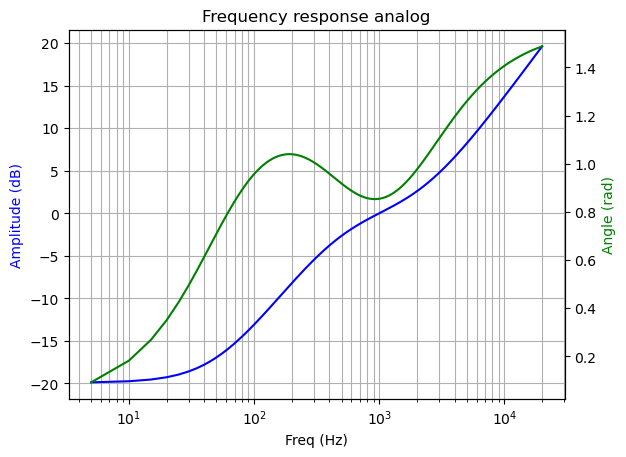

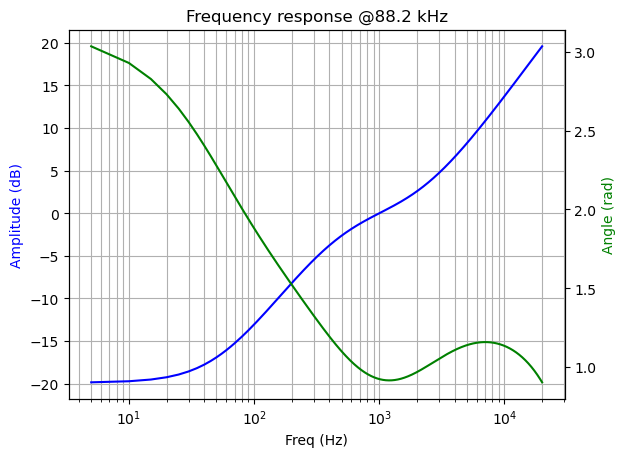

0.9999999999999999 0.9999999999999999 1.0


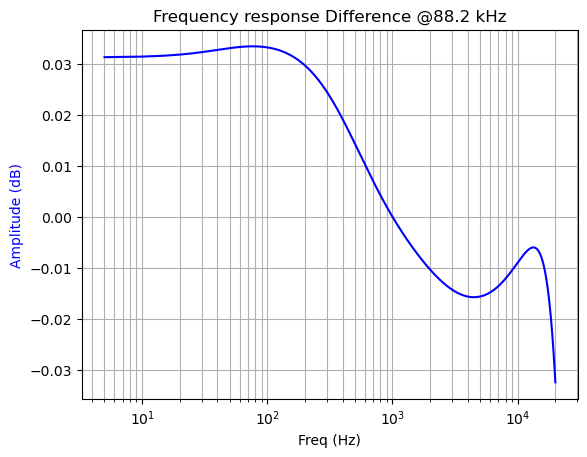

In [8]:
k  = '88.2'
fs = float (k) * 1000.0
d  = riaa_record_from_forum [k]

# Compute recording RIAA analog filter by reversing poles and zeros
recording_filts = compute_analog_filter (riaa ['spole'], riaa ['szero'])

pd = d ['w']
rf = recording_filts
w_a, h_a = signal.freqs_zpk (rf.zeros, rf.poles, rf.gain, pd * fs / (np.pi * 2))
plot_response (pd, h_a, title = 'analog', fs = fs, logx = True, do_angle=1)

# Tune gain of digital filter to 0dB @1kHz
w_c, h_c = signal.freqz_zpk (d ['z'], d ['p'], d ['g'], [1000 / fs * (2 * np.pi)])
d ['g'] = d ['g'] / abs (h_c [0])
#print ('digital gain:', d ['g'])
#print ('@1kHz:', abs (h_c [0]))
d ['w'], d ['h'] = signal.freqz_zpk (d ['z'], d ['p'], d ['g'], d ['w'])
plot_response (d ['w'], d ['h'], title = '@%s kHz' % k, fs = fs, logx = True, do_angle=1)
print (abs (d ['h'][199]), abs (h_a [199]), abs (d ['h'][199]) / abs (h_a [199]))
plot_response (d ['w'], abs (d ['h']) / abs (h_a), title = 'Difference @%s kHz' % k, fs = fs, logx = True)

In the following we have the parameters for *playback* from the forum post.
Note that when displaying the poles at the end we have

In [9]:
# Later in same forum post, these are the playback values
riaa_playback_from_forum = \
{   '44.1' :
    dict
        ( a = [ 1.0000000000, -1.7007240000,  0.7029381524 ]
        , b = [ 1.0000000000, -0.7218922000, -0.1860520545 ]
        )
,   '48.0' :
    dict
        ( a = [ 1.0000000000, -1.7327655000,  0.7345534436 ]
        , b = [ 1.0000000000, -0.7555521000, -0.1646257113 ]
        )
,   '88.2' :
    dict
        ( a = [ 1.0000000000, -1.8554648000,  0.8559721393 ]
        , b = [ 1.0000000000, -0.8479577000, -0.1127631993 ]
        )
,   '96.0' :
    dict
        ( a = [ 1.0000000000, -1.8666083000,  0.8670382873 ]
        , b = [ 1.0000000000, -0.8535331000, -0.1104595113 ]
        )
}
for k in riaa_playback_from_forum :
    fs = float (k) * 1000.
    d = riaa_playback_from_forum [k]
    d ['w'], d ['h'] = signal.freqz (d ['b'], d ['a'])
    d ['wg'], d ['gd'] = signal.group_delay ((d ['b'], d ['a']))
    d ['zero'], d ['pole'], d ['gain'] = signal.tf2zpk (d ['b'], d ['a'])
    print ("zeros:", d ["zero"], "poles:", d ["pole"], "gain:", d ["gain"])

zeros: [ 0.923382  -0.2014898] poles: [0.9924091 0.7083149] gain: 1.0
zeros: [ 0.932159  -0.1766069] poles: [0.993133  0.7396325] gain: 1.0
zeros: [ 0.9648312 -0.1168735] poles: [0.9964002 0.8590646] gain: 1.0
zeros: [ 0.9676817 -0.1141486] poles: [0.9966946 0.8699137] gain: 1.0


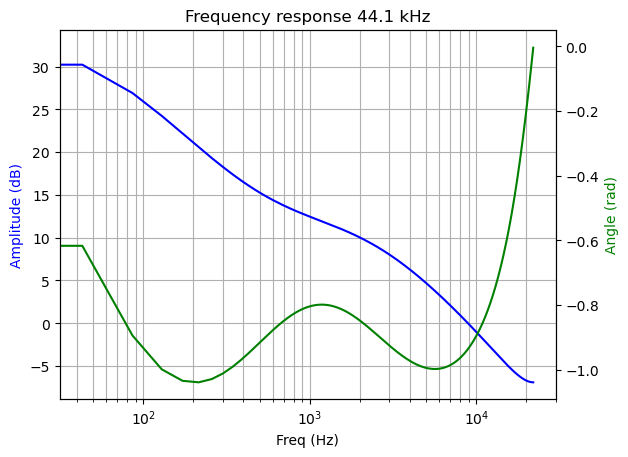

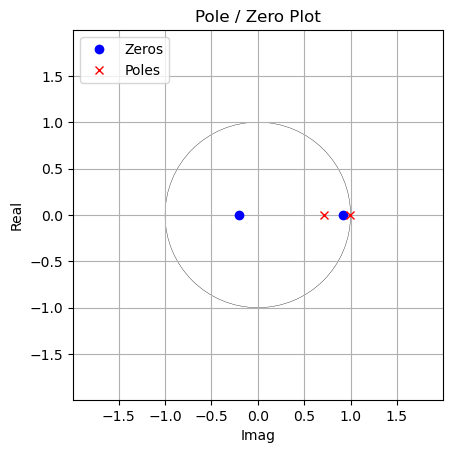

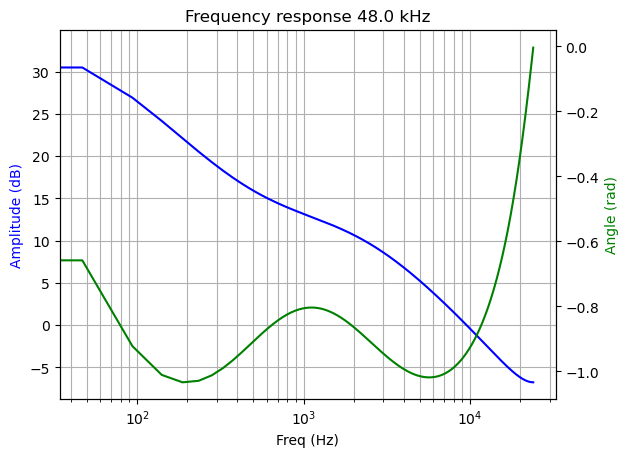

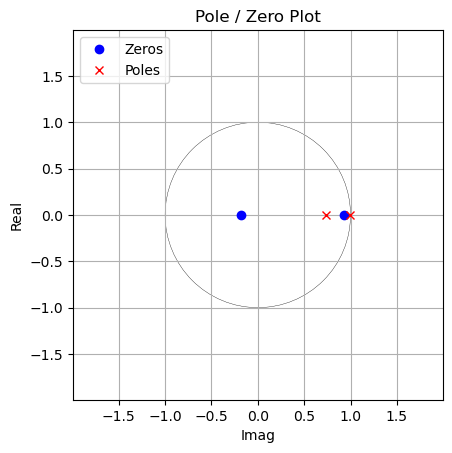

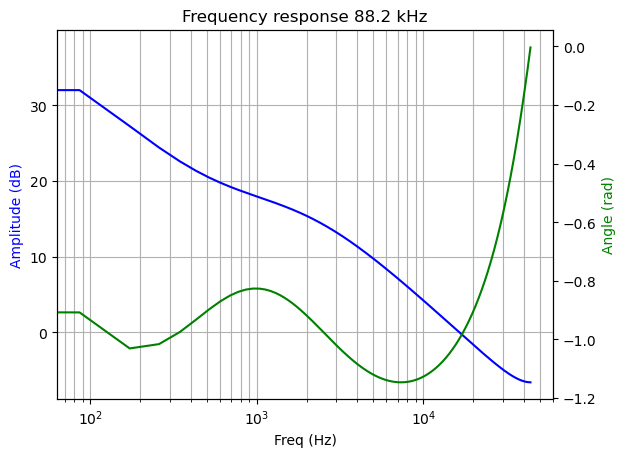

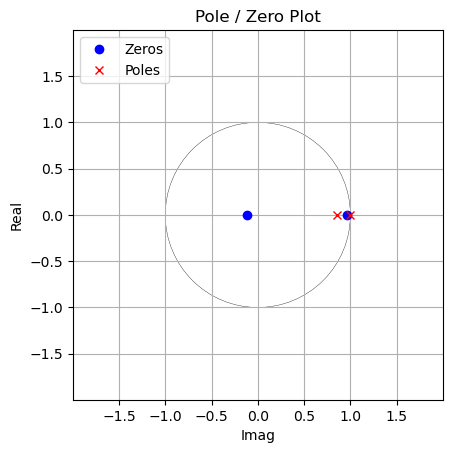

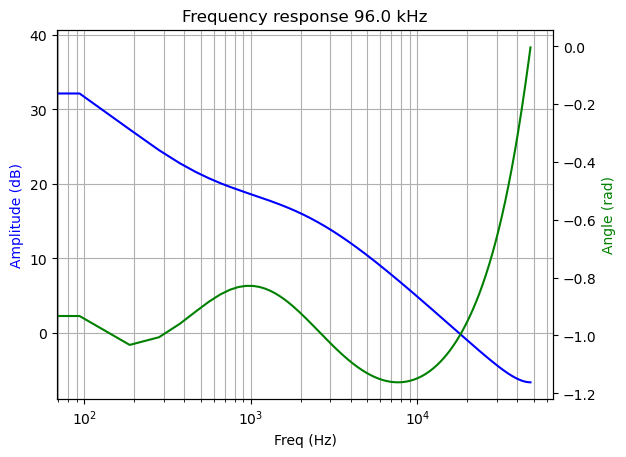

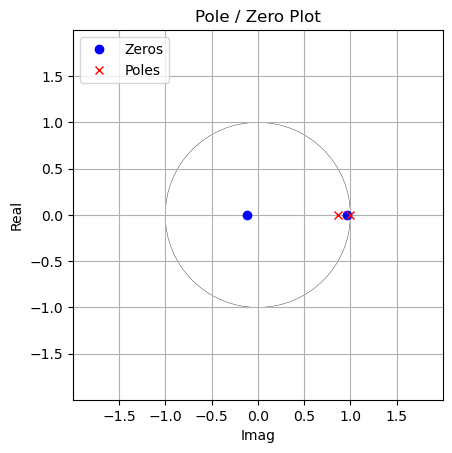

In [10]:
for k in riaa_playback_from_forum :
    d = riaa_playback_from_forum [k]
    plot_response (d ['w'], d ['h'], '%s kHz' % k, fs = 1000 * float (k), logx=1, do_angle=1)
    pole_zero_plot (d ['pole'], d ['zero'])
    #plot_delay (d ['wg'], d ['gd'], title = '%s kHz' % k, fs = 1000 * float (k), logx=1)

## Source Code from `sox`
[RIAA equalization:](https://en.wikipedia.org/wiki/RIAA_equalization)
Coefficients taken from sox source-code in file `biquads.c`, this
has different polynomials for different sampling rates.

Note that the python-code below with comment
starting "Check that RIAA params..." checks that the a/b
parameters match with the parameters from the forum post
above. So it seems that the sox parameters are derived
from that forum post or some other source that has its
origing there.

We are normalizing the paramters so that the gain @1kHz
is 0dB as specified in the RIAA spec (or at least in what
Wikipedia has about the spec). As you can seen in the plots
the different curves for the different sampling frequencies
do not match.

Digital Gain: 0.23806122326320717 Gain @1kHz: 1.0


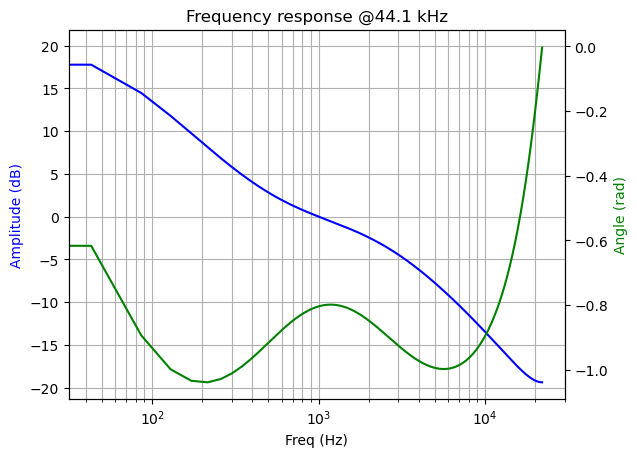

a: [ 1.         -1.700724    0.70293815] b: [ 0.23806122 -0.17185454 -0.04429178]
zeros: [-0.2014898  0.923382 ] poles: [0.7083149 0.9924091]


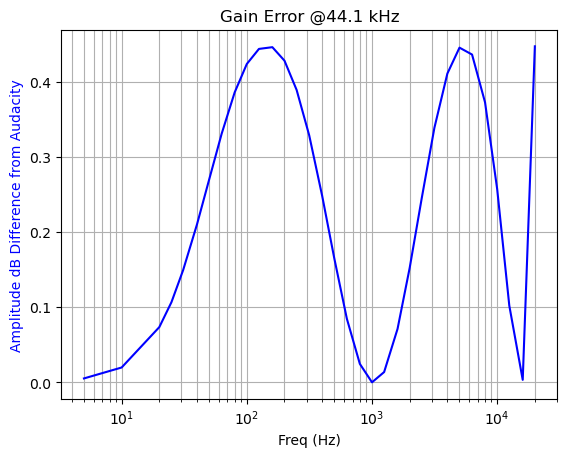

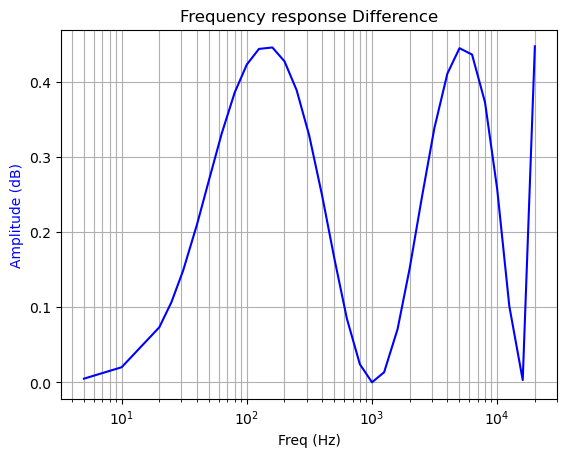

Digital Gain: 0.21973782308586043 Gain @1kHz: 1.0000000000000002


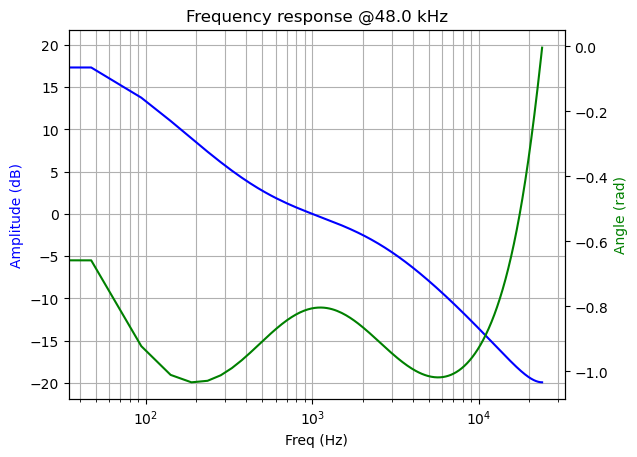

a: [ 1.         -1.7327655   0.73455344] b: [ 0.21973782 -0.16602337 -0.0361745 ]
zeros: [-0.1766069  0.932159 ] poles: [0.7396325 0.993133 ]


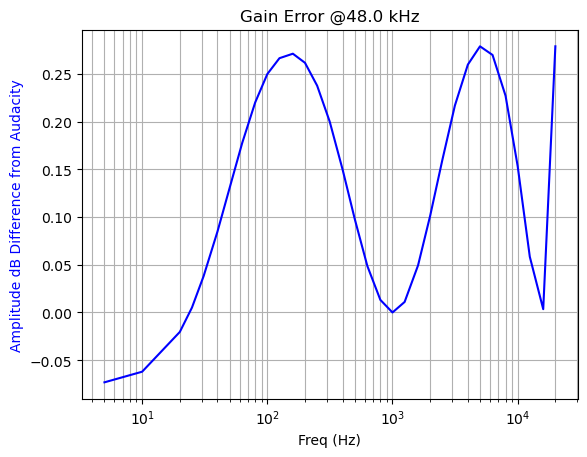

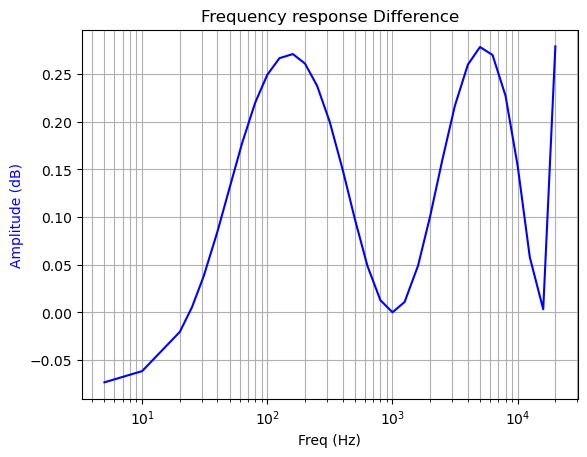

Digital Gain: 0.12671063520519438 Gain @1kHz: 1.0000000000000002


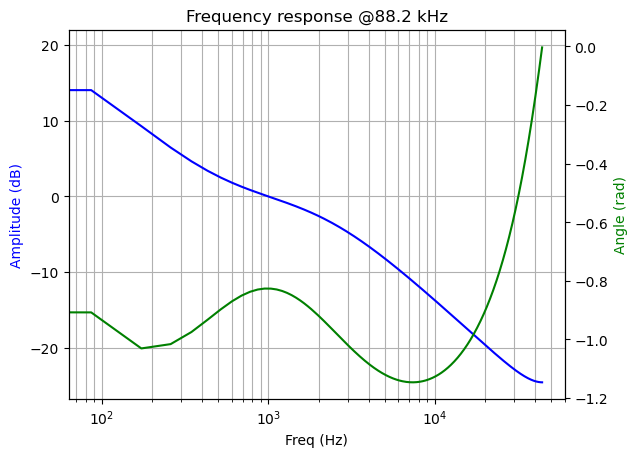

a: [ 1.         -1.8554648   0.85597214] b: [ 0.12671064 -0.10744526 -0.0142883 ]
zeros: [-0.1168735  0.9648312] poles: [0.8590646 0.9964002]


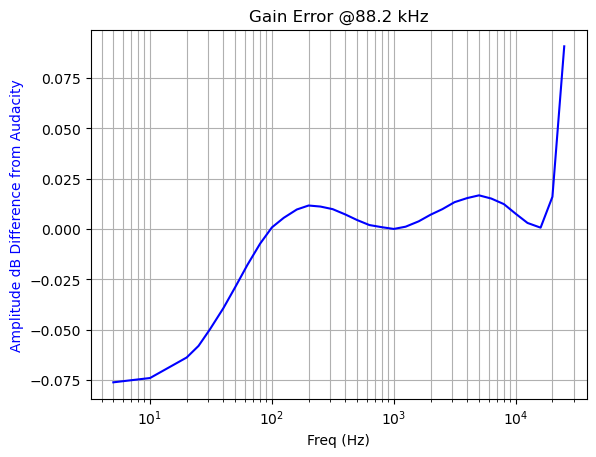

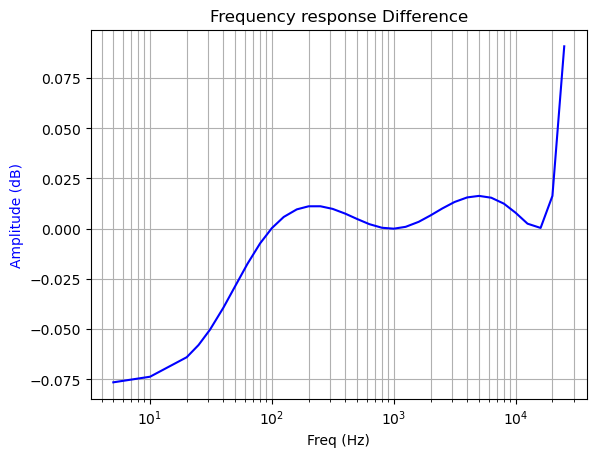

Digital Gain: 0.11714782103050894 Gain @1kHz: 0.9999999999999999


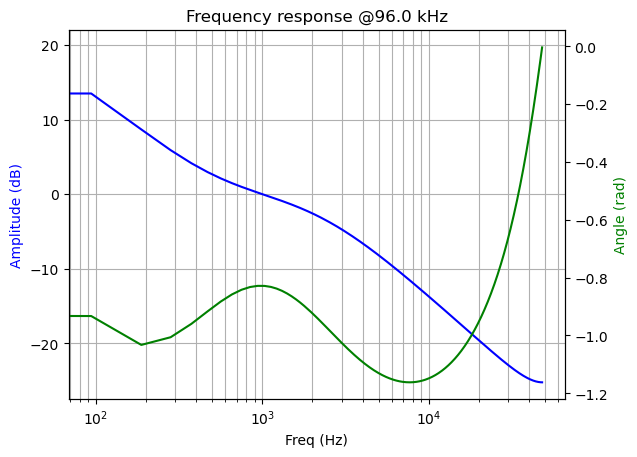

a: [ 1.         -1.8666083   0.86703829] b: [ 0.11714782 -0.09998954 -0.01294009]
zeros: [-0.1141486  0.9676817] poles: [0.8699137 0.9966946]


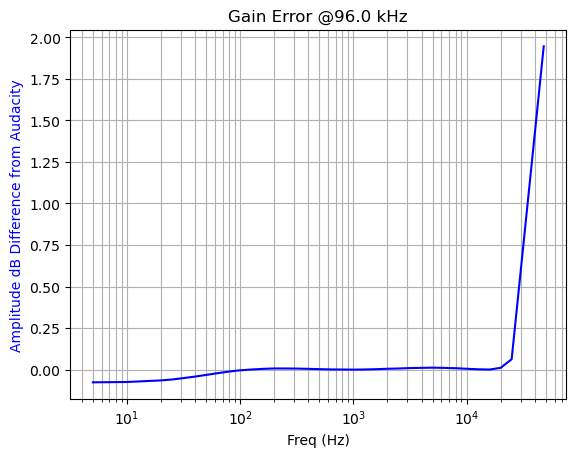

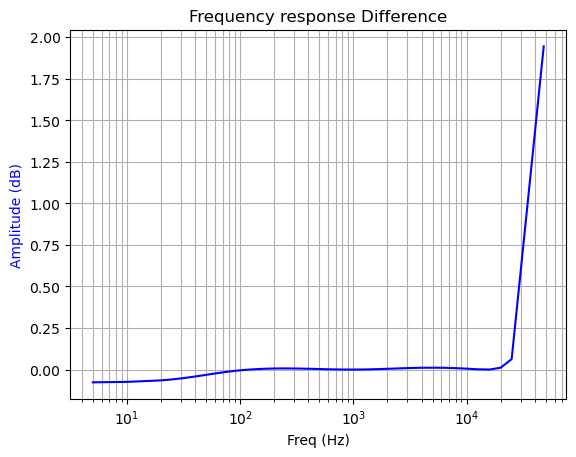

In [11]:
# Values from source-code of sox
sox_riaa = {}
sox_riaa ['44.1'] = dict \
    ( zero = np.array ([-0.2014898, 0.9233820])
    , pole = np.array ([ 0.7083149, 0.9924091])
    )
sox_riaa ['48.0'] = dict \
    ( zero = np.array ([-0.1766069, 0.9321590])
    , pole = np.array ([ 0.7396325, 0.9931330])
    )
sox_riaa ['88.2'] = dict \
    ( zero = np.array ([-0.1168735, 0.9648312])
    , pole = np.array ([ 0.8590646, 0.9964002])
    )
sox_riaa ['96.0'] = dict \
    ( zero = np.array ([-0.1141486, 0.9676817])
    , pole = np.array ([ 0.8699137, 0.9966946])
    )

# Check that RIAA params from forum are identical with sox params
for k in riaa_playback_from_forum :
    for zp in 'zero', 'pole' :
        for n1, n2 in zip (sorted (sox_riaa [k][zp]), sorted (riaa_playback_from_forum [k][zp])) :
            #print (n1, n2, n1 - n2)
            assert abs (n1 - n2) < 5e-10

(b, a) = signal.zpk2tf (sox_riaa ['44.1']['zero'], sox_riaa ['44.1']['pole'], 1.0)
w, h = signal.freqz (b, a)
wg, gd = signal.group_delay ((b, a))
#plot_response (w, h, fs=44100, logx = True, do_angle=1)

# Normalize to 0dB for 1kHz
digital_gain = 1.0
for rk in sox_riaa :
    sr = sox_riaa [rk]
    fs = float (rk) * 1000.0
    z1kHz = 1000.0 / fs * 2 * np.pi
    for k in range (2) :
        (sr ['nb'], sr ['na']) = signal.zpk2tf (sr ['zero'], sr ['pole'], digital_gain)
        w, h = signal.freqz (sr ['nb'], sr ['na'], [z1kHz])
        #print (w, h, abs (h))
        digital_gain = abs (digital_gain / abs (h [0]))
        #print ("digital gain:", digital_gain)
    print ("Digital Gain:", digital_gain, "Gain @1kHz:", abs (h [0]))
    w, h = signal.freqz (sr ['nb'], sr ['na'])
    plot_response (w, h, fs=fs, logx = True, title = '@%s kHz' % rk, do_angle=1)
    print ("a:", sr ['na'], 'b:', sr ['nb'])
    print ("zeros:", sr ['zero'], "poles:", sr ['pole'])
    compare_to_audacity (sr ['na'], sr ['nb'], fs)
    r    = plot_range (fs, audacity_frq)
    rd   = plot_range_digi (fs, r)
    w, h = signal.freqz (sr ['nb'], sr ['na'], rd)
    plot_response (rd, abs (h) / abs (r_a_h [:len(r)]), fs = fs, title = 'Difference', logx=1)
    #print ("Orig FRQ for fs=%s kHz:" % rk)
    #print ("Analog Zeros:", 1.0 / (np.log (abs (sr ['zero'])) * fs))
    #print ("FRQ    Zeros:", np.log (abs (sr ['zero'])) * fs / (2 * np.pi))
    #print ("Analog Poles:", 1.0 / (np.log (abs (sr ['pole'])) * fs))

### Compute From S-Plane Filter Parameters taken from Wikipedia

In [12]:
def get_fmax_d_amax (fs, filts, fmax = None) :
    if fmax is None :
        fmax = fs / 2
    fmax_d = (fmax / fs * 2 * np.pi)
    w, h = signal.freqs_zpk (filts.zeros, filts.poles, filts.gain, [fmax])
    abs_h_analog_fmax = abs (h [0])
    return fmax_d, abs_h_analog_fmax
# end def get_fmax_d_amax

def add_neg_zero (filtz, fmax_d, amax) :
    """ Search for a negative zero to dampen the response @fmax
    """
    z = list (sorted (filtz.zeros))
    r = min (z [0], -0.01)
    l = -1
    e = 0.00001
    
    zero = (l + r) / 2
    z.append (zero)
    print ('r, z:', r, z)
    w, h = signal.freqz_zpk (filtz.zeros, filtz.poles, filtz.gain, [fmax_d])
    print (abs (h [0]), amax, abs (h [0]) / amax, 20 * np.log10 (abs (h [0]) / amax))
    g = filtz.gain
    for k in range (10) :
        zero   = (l + r) / 2
        z [-1] = zero
        w, h = signal.freqz_zpk (z, filtz.poles, g, [f1kHz])
        g = g / h [0]
        w, h = signal.freqz_zpk (z, filtz.poles, g, [fmax_d, f1kHz])
        #print ('@1kHz:', abs (h [1]))
        #print ("zero, a, aa, a/aa", zero, abs (h [0]), amax, abs (h [0]) / amax)
        v = 20 * np.log10 (abs (h [0]) / amax)
        #print ('v:', v)
        if abs (v) < e :
            break
        if v < 0 :
            l = zero
        else :
            r = zero
        #print ('l, r, zero', l, r, zero)
        #print (z)
        #wz, hz = signal.freqz_zpk (z, filtz.poles, g, rd)
        #plot_response (rd, abs (hz) / abs (r_a_h [:len(rd)]), fs = fs, title = 'Iter: %s' % k, logx=1)
        w, h = signal.freqz_zpk (z, filtz.poles, g, [f1kHz])
        g = g / h [0]
        filtz.zeros = np.array (z)
        filtz.gain  = g
# end def add_neg_zero

zeros, poles: [-500.48724243] [  -50.04872424 -2122.06590789]


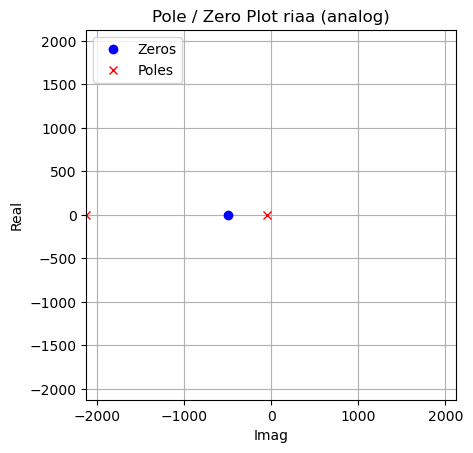

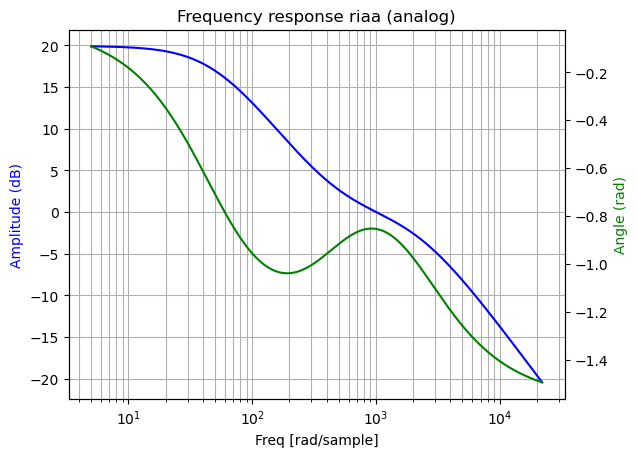

Filter: riaa, Sampling Frequency: 44100
digital gain (matched Z-Transform): 0.2663973182433689
zeros, poles: [0.93117565] [0.99289463 0.7390844 ]


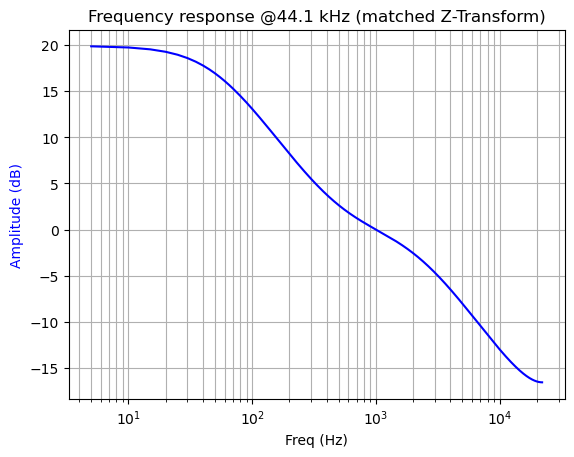

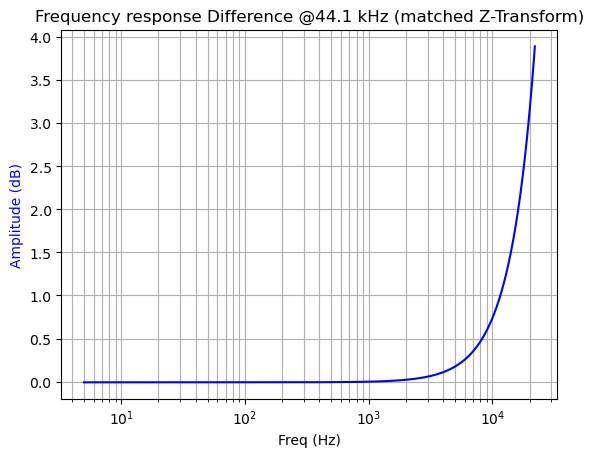

Adding zero for Optimizing @13.525 kHz
r, z: -0.01 [0.9311756522967054, -0.505]
0.17984040195121753 0.15352737046146814 1.1713898402002096 1.3740290589554218
z: [ 0.93117565 -0.12891602]


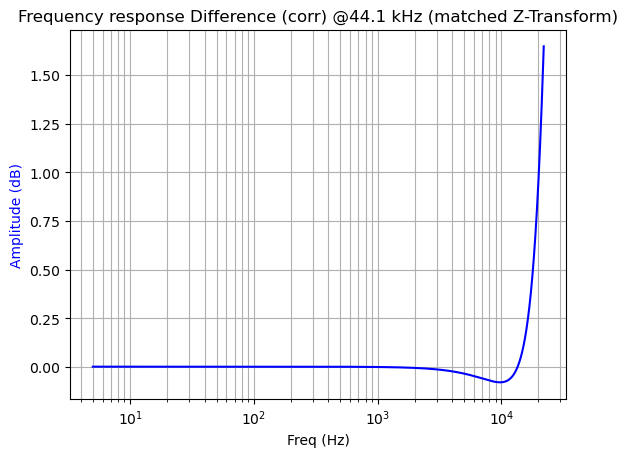

digital gain (bilinear Transform): 0.2677664215985802
zeros, poles: [0.9311475] [0.9928946  0.73736047]


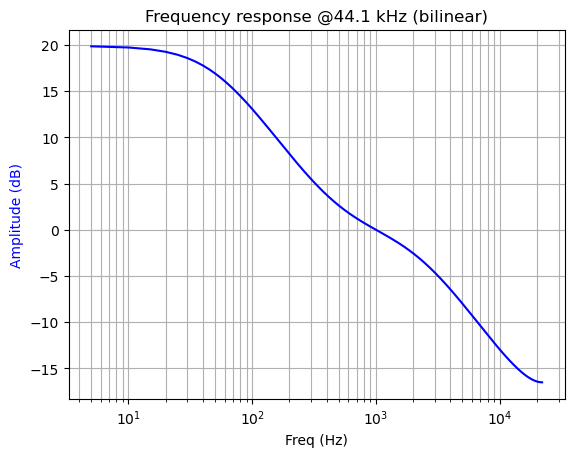

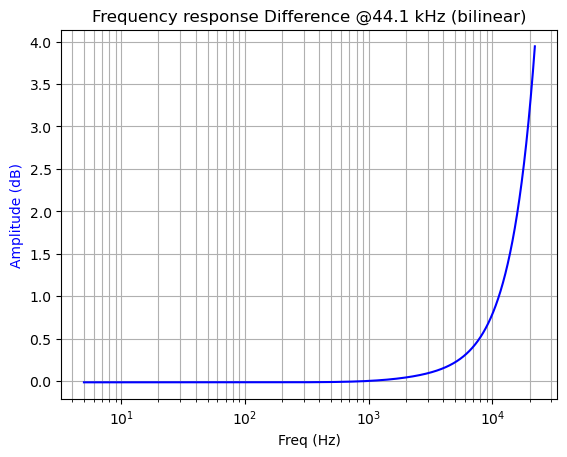

Filter: riaa, Sampling Frequency: 48000
digital gain (matched Z-Transform): 0.24702604006921142
zeros, poles: [0.93658628] [0.99347005 0.75746513]


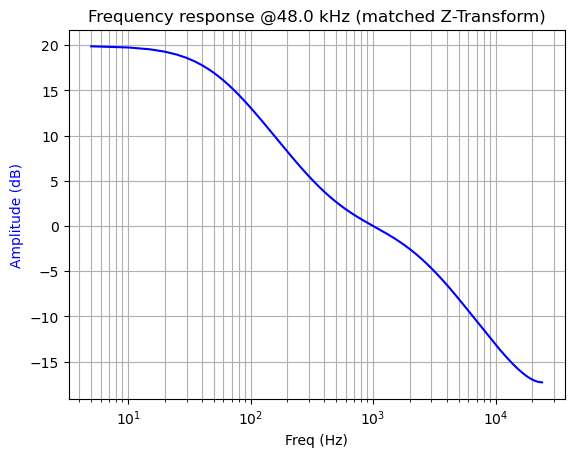

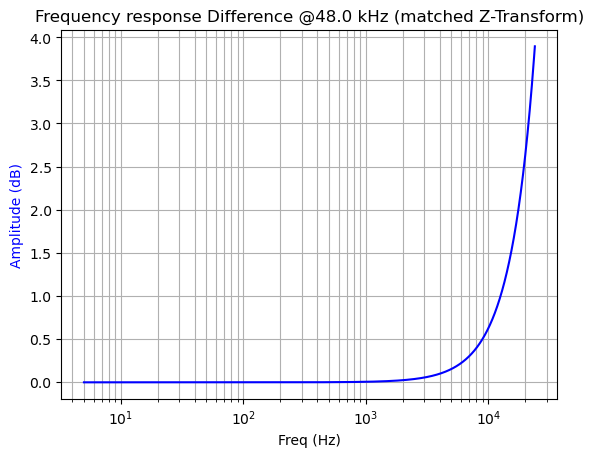

Adding zero for Optimizing @14.5 kHz
r, z: -0.01 [0.9365862839664941, -0.505]
0.16721667207511984 0.14341545914047887 1.1659598838039287 1.3336721655387827
z: [ 0.93658628 -0.12698242]


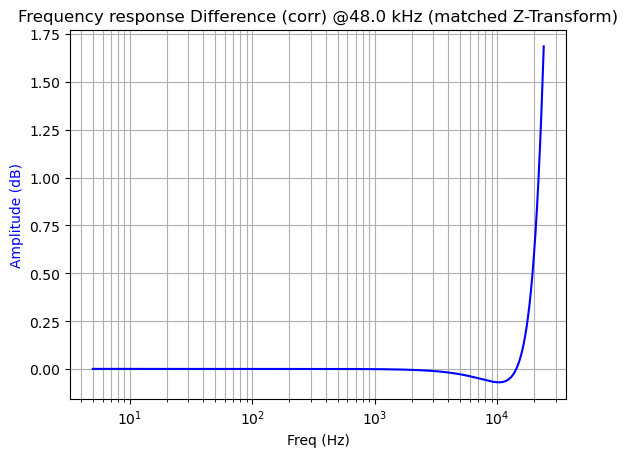

digital gain (bilinear Transform): 0.24811303167772397
zeros, poles: [0.93656432] [0.99347003 0.75609756]


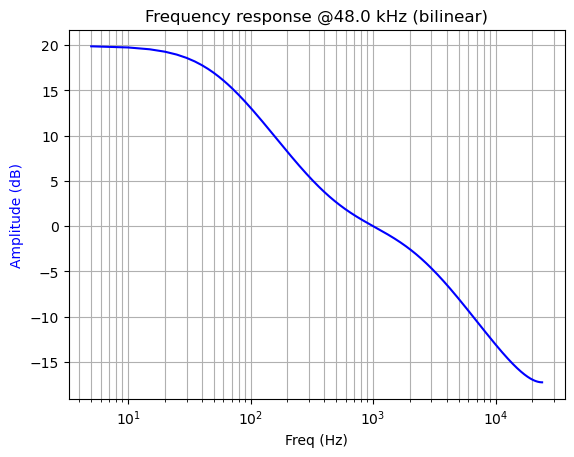

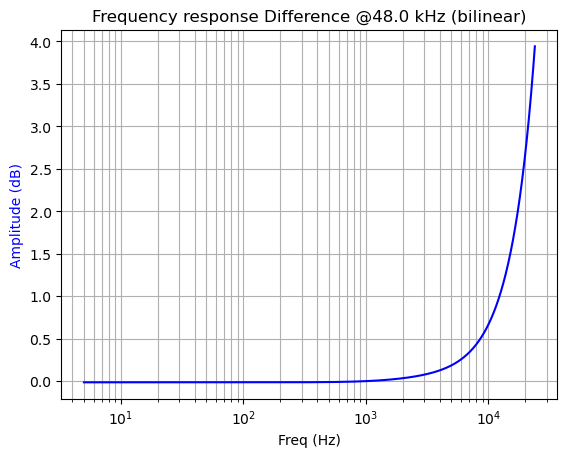

Filter: riaa, Sampling Frequency: 88200
digital gain (matched Z-Transform): 0.14107868921527725
zeros, poles: [0.96497443] [0.99644098 0.85970018]


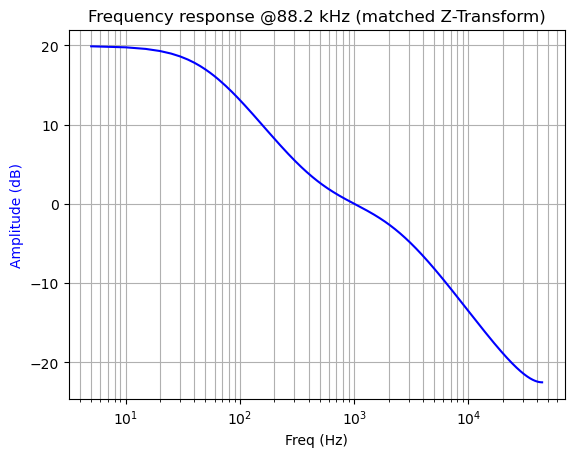

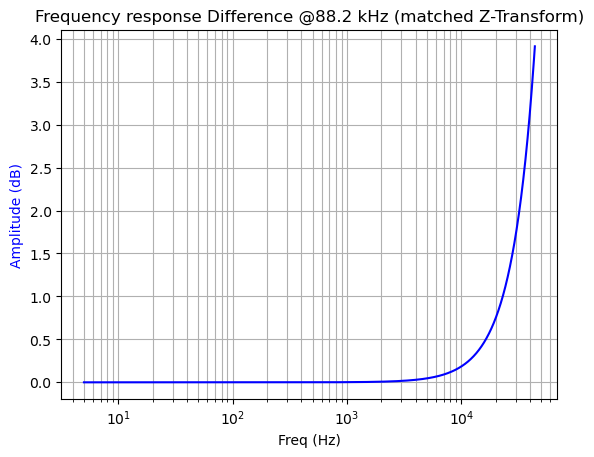

Adding zero for Optimizing @17.0 kHz
r, z: -0.01 [0.9649744309030708, -0.505]
0.13044853249544644 0.12265623849886338 1.0635295366297677 0.5349911149995866
z: [ 0.96497443 -0.11151367]


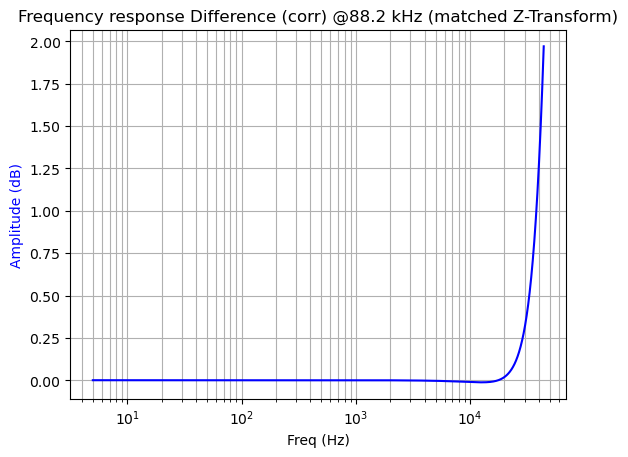

digital gain (bilinear Transform): 0.14127670726556257
zeros, poles: [0.96497079] [0.99644098 0.85945186]


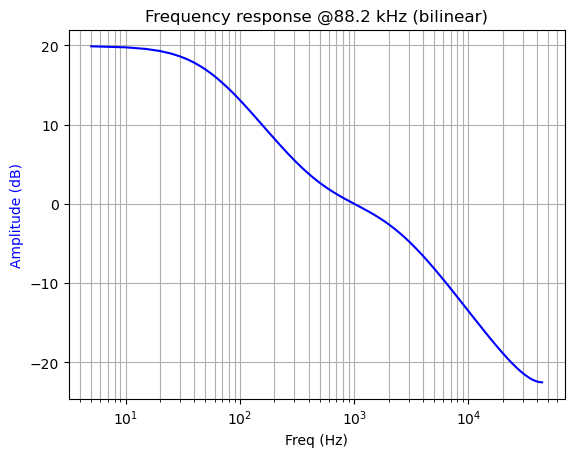

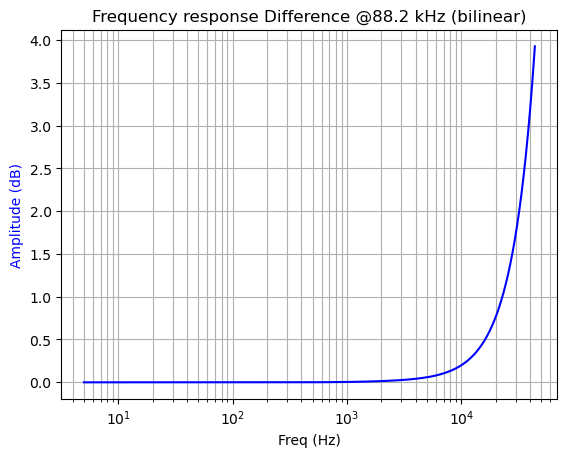

Filter: riaa, Sampling Frequency: 96000
digital gain (matched Z-Transform): 0.13023063912766566
zeros, poles: [0.96777388] [0.99672968 0.87032473]


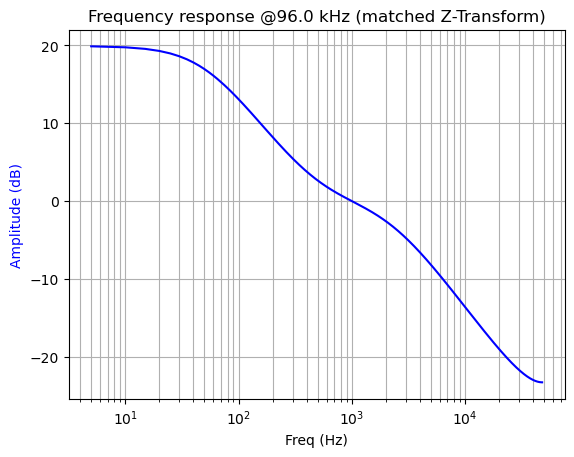

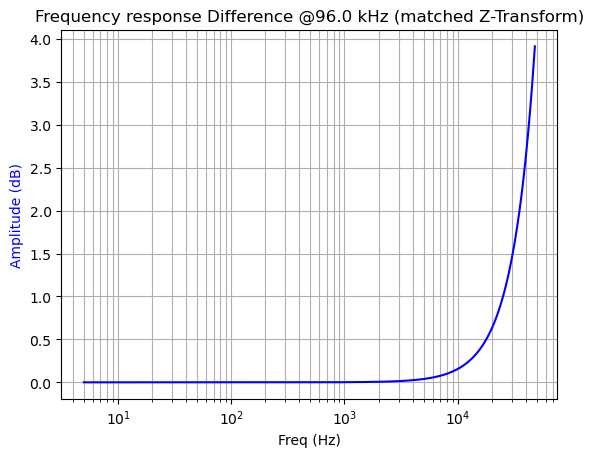

Adding zero for Optimizing @17.0 kHz
r, z: -0.01 [0.9677738805973708, -0.505]
0.1291899053807281 0.12265623849886338 1.0532681171526816 0.4507787623250554
z: [ 0.96777388 -0.10958008]


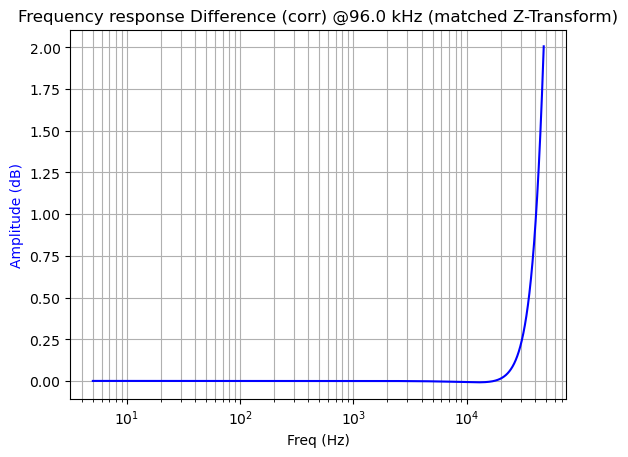

digital gain (bilinear Transform): 0.13038606123330113
zeros, poles: [0.96777105] [0.99672967 0.87012987]


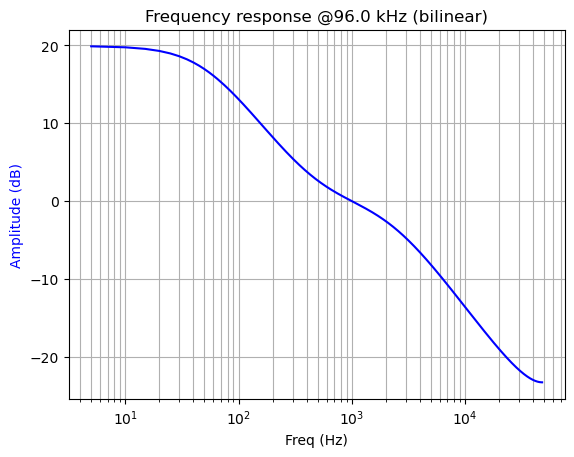

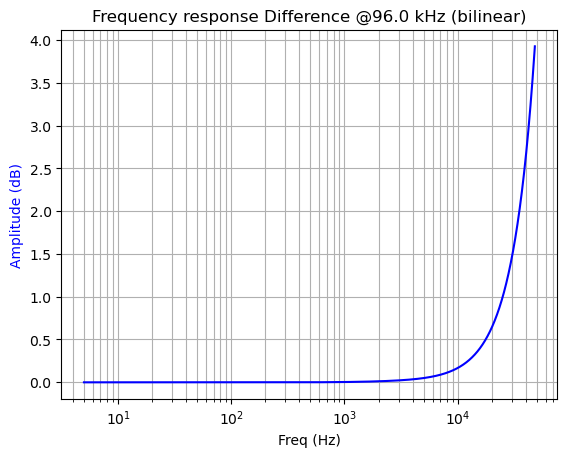

In [13]:
for filter in [riaa] :
    filts = compute_analog_filter (filter ['szero'], filter ['spole'])
    print ("zeros, poles:", filts.zeros, filts.poles)
    title = '%s (analog)' % filter ['name']
    pole_zero_plot (filts.poles, filts.zeros, title = title)
    ws, hs = signal.freqs_zpk (filts.zeros, filts.poles, filts.gain, np.array (list (range (5, 22000))))
    plot_response (ws, hs, title = title, logx = True, do_angle = 1)
    for fs in (44100., 48000., 88200., 96000.) :
        print ("Filter: %s, Sampling Frequency: %d" % (filter ['name'], fs))
        f1kHz = 1000 / fs * np.pi * 2
        ra = plot_range      (fs)
        rd = plot_range_digi (fs, ra)
        ws, hs = signal.freqs_zpk (filts.zeros, filts.poles, filts.gain, ra)

        # Convert by Matched Z-Transform to digital filter
        zzeros = np.exp (filts.zeros * 2 * np.pi / fs)
        zpoles = np.exp (filts.poles * 2 * np.pi / fs)
        filtz  = signal.lti (zzeros, zpoles, 1.0)
        #pole_zero_plot (filtz.poles, filtz.zeros, title = '(Matched Z-Transform)')
        # Adjust gain to 0dB @1kHz
        wz, hz = signal.freqz_zpk (filtz.zeros, filtz.poles, filtz.gain, [f1kHz])
        filtz.gain = filtz.gain / abs (hz [0])
        print ("digital gain (matched Z-Transform):", filtz.gain)
        print ("zeros, poles:", filtz.zeros, filtz.poles)
        wz, hz = signal.freqz_zpk (filtz.zeros, filtz.poles, filtz.gain, rd)
        title = '@%s kHz (matched Z-Transform)' % (fs / 1000)
        plot_response (wz, hz, title = title, fs = fs, logx=1)
        #print ('end-hz:', abs (hz [-3:]))
        plot_response (rd, abs (hz) / abs (hs), fs = fs, title = 'Difference ' + title, logx=1)
        
        # Optimize for error 0 in the middle of 5kHz and fs/2 but at most 17kHz
        fopt = min (17000.0, ((fs / 2) + 5000.0) / 2)
        print ("Adding zero for Optimizing @%s kHz" % (fopt / 1000))
        for f in fopt, :
            fmax_d, amax = get_fmax_d_amax (fs, filts, f)
            add_neg_zero (filtz, fmax_d, amax)
            print ("z:", filtz.zeros)
        wz, hz = signal.freqz_zpk (filtz.zeros, filtz.poles, filtz.gain, rd)
        plot_response (rd, abs (hz) / abs (hs), fs = fs, title = 'Difference (corr) ' + title, logx=1)
        
        # Convert by bilinear transform
        filtz = signal.lti (*signal.bilinear_zpk (filts.zeros * 2 * np.pi, filts.poles * 2 * np.pi, filts.gain, fs))
        # Remove the zero at -1 (!) (which happens to be at index -1)
        filtz.zeros = np.array ([z for z in filtz.zeros if z != -1])
        # Adjust gain to 0dB @1kHz
        wz, hz = signal.freqz_zpk (filtz.zeros, filtz.poles, filtz.gain, [1000 / fs * np.pi * 2])
        filtz.gain = filtz.gain / abs (hz [0])
        print ("digital gain (bilinear Transform):", filtz.gain)
        print ("zeros, poles:", filtz.zeros, filtz.poles)
        #wz, hz = signal.freqz_zpk (filtz.zeros, filtz.poles, filtz.gain)
        wz, hz = signal.freqz_zpk (filtz.zeros, filtz.poles, filtz.gain, rd)
        #pole_zero_plot (filtz.poles, filtz.zeros, limit=1.1)
        title = '@%s kHz (bilinear)' % (fs / 1000)
        plot_response (wz, hz, title = title, fs = fs, logx=1)
        plot_response (rd, abs (hz) / abs (hs), fs = fs, title = 'Difference ' + title, logx=1)